<a href="https://colab.research.google.com/github/nicolasvazquez95/Aprendiendo_DeepLearning/blob/main/projects/03_BitPredict_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BitPredict Project: Time series & Deep Learning
_Forecasting Bitcoin prices_ 💰

This data is historical price data of Bitcoin, downloaded from Coindesk

In [1]:
## Get data (Bitcoin price data)
## Link: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-06-04 01:08:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.004s  

2022-06-04 01:08:44 (38.1 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



# Import data

In [19]:
import pandas as pd
df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'])
df.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2013-10-01,123.65499,124.30466,124.75166,122.56349
1,BTC,2013-10-02,125.45500,123.65499,125.75850,123.63383
2,BTC,2013-10-03,108.58483,125.45500,125.66566,83.32833
3,BTC,2013-10-04,118.67466,108.58483,118.67500,107.05816
4,BTC,2013-10-05,121.33866,118.67466,121.93633,118.00566


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2787 entries, 0 to 2786
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Currency             2787 non-null   object        
 1   Date                 2787 non-null   datetime64[ns]
 2   Closing Price (USD)  2787 non-null   float64       
 3   24h Open (USD)       2787 non-null   float64       
 4   24h High (USD)       2787 non-null   float64       
 5   24h Low (USD)        2787 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 130.8+ KB


# Visualizing data

In [23]:
bitcoin_prices = pd.DataFrame(df[['Date','Closing Price (USD)']]).rename(columns={'Closing Price (USD)':'Price'})

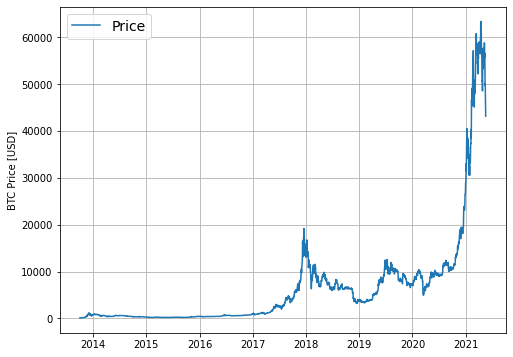

In [25]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(bitcoin_prices['Date'],bitcoin_prices['Price'],label='Price')
plt.ylabel('BTC Price [USD]'); plt.legend(fontsize=14);plt.grid()

# Split data intro train-test sets

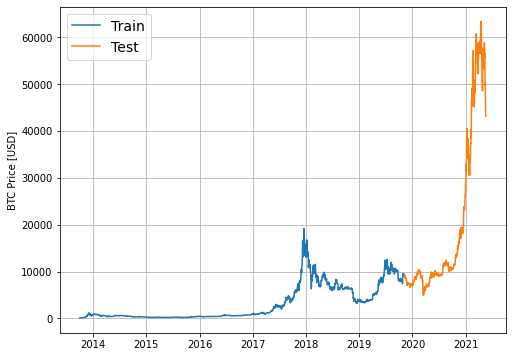

In [29]:
split_size = int(0.8*len(bitcoin_prices))

X_train = bitcoin_prices['Date'].dt.to_pydatetime()[:split_size]
y_train = bitcoin_prices['Price'][:split_size].to_numpy()

X_test = bitcoin_prices['Date'].dt.to_pydatetime()[split_size:]
y_test = bitcoin_prices['Price'][split_size:].to_numpy()

plt.figure(figsize=(8,6))
plt.plot(X_train,y_train,label='Train')
plt.plot(X_test,y_test,label='Test')
plt.ylabel('BTC Price [USD]'); plt.legend(fontsize=14);plt.grid()

# Modelling experiments 

## Model 0: Naïve model (baseline)
$$y_t = y_{t-1}$$

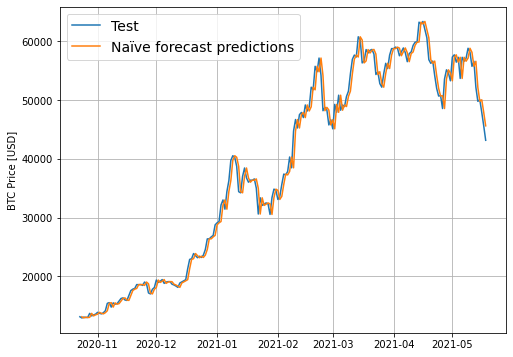

In [34]:
naive_forecast = y_test[:-1]

plt.figure(figsize=(8,6))
plt.plot(X_test[350:],y_test[350:],label='Test')
plt.plot(X_test[351:],naive_forecast[350:],label='Naïve forecast predictions')
plt.ylabel('BTC Price [USD]'); plt.legend(fontsize=14);plt.grid()

## Defining metrics for evaluating models
* MASE (_mean absolute scaled error_)

In [40]:
import tensorflow as tf

In [38]:
# MASE implementation in TF
def MASE(y_true,y_pred):
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))
  mae_naive = tf.reduce_mean(tf.abs(y_true[1:]- y_true[:-1]))
  return mae/mae_naive

In [41]:
# Different evaluation metrics together into a function.
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase_ = mase(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase_.numpy()}

## Format data: Windowing our dataset 
We need to turn our data into a supervised learning problem. 

In [54]:
import numpy as np
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [56]:
WINDOW_SIZE = 7
HORIZON = 1
full_windows, full_labels = make_windows(bitcoin_prices['Price'].to_numpy(), window_size=WINDOW_SIZE, horizon=HORIZON)

In [60]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [61]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)